In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import peakutils
from smitting.fitting import LMFit
from smitting.distributions import Lorentzian, Gaussian
from symfit.core.minimizers import *

In [2]:
import symfit

In [3]:
controls = np.genfromtxt('Bwt(DS2)_controls2.txt').T
controls.shape

(11, 2017)

In [4]:
c_data = {
    'ND': np.stack([controls[0], controls[2]]),
    'Native': np.stack([controls[3], controls[5]]),
    'FD': np.stack([controls[7], controls[9]])
}


for k, v in c_data.items():
    x, y = v
    
    #Calculate and subtract baseline
    bl = peakutils.baseline(y, 1)
    y_corr = y-bl
    
    #Normalize to 1
    y_corr /= np.trapz(y_corr, x)
    
    c_data[k] = np.stack([x, y_corr])

In [5]:
data_table = np.genfromtxt('Bwt(DS2)_data.txt').T
data_table.shape

(39, 2017)

In [6]:
labels = np.array(['1h', '30m', '20m', '15m', '10m', '5m', '1m', '40s', '20s', 't0'])
time = np.array([60*60, 30*60, 20*60, 15*60, 10*60, 5*60, 1*60, 40, 20, 0])

In [7]:
data_raw = [np.stack([data_table[0], data_table[2]/100])] + [np.stack([data_table[(4*i)-1], data_table[(4*i)+1]/100]) for i in np.arange(9) + 1]

data_out = []
for d in data_raw:
    x, y = d
    bl = peakutils.baseline(y, 1)
    
    y_corr = y-bl
    y_corr /= np.trapz(y_corr, x)
    
    data_out.append([x, y_corr])
    
f_data = np.array(data_out)
f_data.shape

(10, 2, 2017)

In [8]:
global_x = c_data['Native'][0]
native = c_data['Native'][1]
FD = np.interp(global_x, *c_data['FD'])

In [9]:
data_arr = np.stack([np.interp(global_x, *d) for d in f_data])
data_arr.shape

(10, 2017)

In [10]:
pip = LMFit(x=x, y=data_arr.T)

bases = {
    'FD': FD,
    'native': native,
    'int1': Lorentzian,
    #'int2': Lorentzian,
    
}

In [11]:
pip.make_model(bases)

In [12]:
pip.parameters

{'A': A, 'mu_x_0': mu_x_0, 'gamma_0': gamma_0}

In [13]:
pip.set_par('mu_x_0', min=800, max=815, value=806)
#pip.set_par('mu_x_1', min=804.5, max=805.5, value=805.1)
pip.set_par('gamma_0', min=0.2, max=2.8, value=0.48, fixed=False)
#pip.set_par('gamma_1', min=0.2, max=2.8, value=1.1, fixed=True)
pip.make_fit(minimizer=MINPACK)

In [15]:
pip.execute()
print(pip.res)

Scalar Parameters:
Parameter | Value       | Standard Deviation
gamma_0     1.512152e+00  None
mu_x_0      8.057695e+02  None

Tensor Parameters:
Parameter | Shape     | Flattened preview 
A           (3, 10)     [1.19e-02 9.81e-03 5.79e-04 ... 6.47e-01 6.93e-01 1.96e-13]

Status message         Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Number of iterations   25
Objective              <symfit.core.objectives.VectorLeastSquares object at 0x00000271619AF3C8>
Minimizer              <symfit.core.minimizers.MINPACK object at 0x000002715B5B3F98>
Linear Solver          <symfit.core.linear_solvers.LstSqBounds object at 0x00000271619D35F8>

Goodness of fit qualifiers:
chi_squared            1.332779911932367
objective_value        [0.00090719 0.00055302 0.00010097 ... 0.00354302 0.00345358 0.00014581]
r_squared              0.9872201007320782


<IPython.core.display.Javascript object>


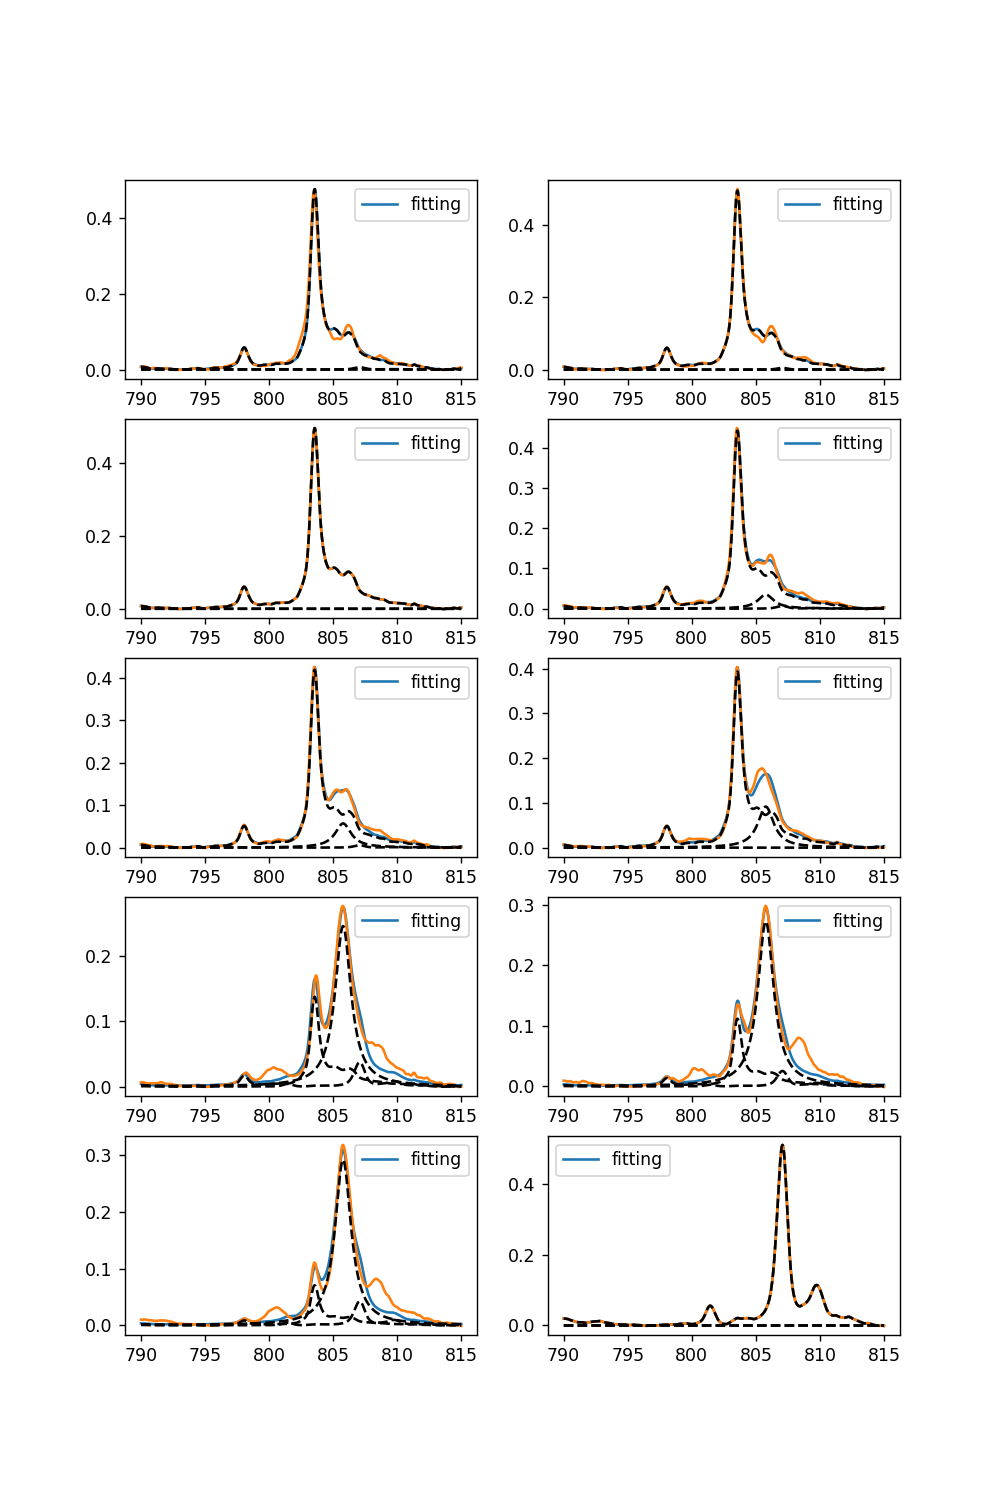

In [16]:
ans = pip.ans
Y = pip.ans.Y
A = pip.res.params['A']

fig, axes = plt.subplots(5, 2, figsize=(8, 12))
for i, ax in enumerate(axes.flatten()):
    a_s = A.T[i]
    ax.plot(x, Y.T[i], label='fitting')
    ax.plot(x, data_arr[i])
    ax.plot(x, a_s[0]*FD, color='k', linestyle='--')
    ax.plot(x, a_s[1]*native, color='k', linestyle='--')
    ax.plot(x, a_s[2]*ans.int1, color='k', linestyle='--')
    #ax.plot(x, a_s[3]*ans.int2, color='k', linestyle='--')

    ax.legend()
plt.show()
#plt.savefig('plotA4_1.png')

In [47]:
A.sum(axis=0)
s= A.sum(axis=0)

In [17]:
plt.figure()
labels = ['FD', 'native', 'i1', 'i2']
for i, a in enumerate(A):
    plt.plot(time, a/s, label=labels[i], marker='o', linestyle=':')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Fraction')

<IPython.core.display.Javascript object>

NameError: name 's' is not defined

<IPython.core.display.Javascript object>


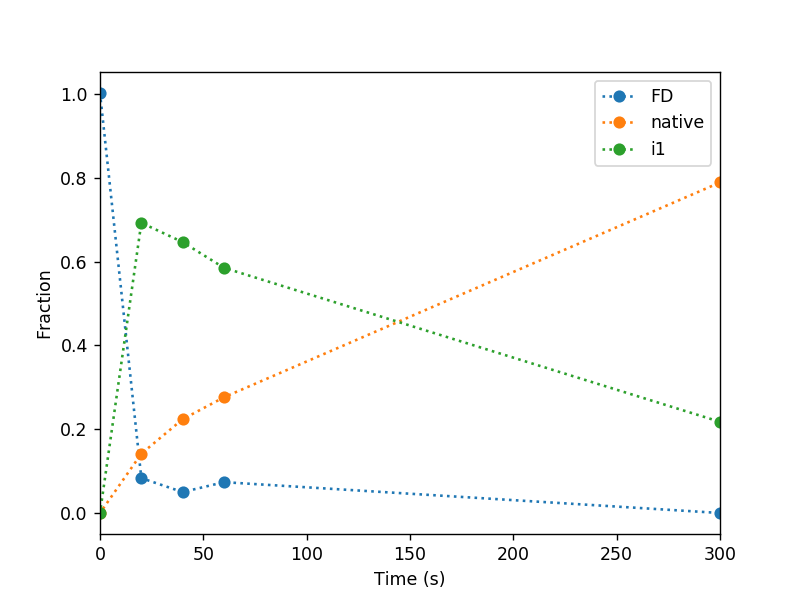

(0, 300)

In [49]:

plt.figure()
labels = ['FD', 'native', 'i1', 'i2']
for i, a in enumerate(A):
    plt.plot(time, a, label=labels[i], marker='o', linestyle=':')

plt.xlabel('Time (s)')
plt.ylabel('Fraction')
plt.legend()
plt.xlim(0, 300)

In [ ]:
A.shape

In [17]:
np.savetxt('Bwt_(DS2-1)_curve', A)